In [1]:
using QuantumOptics
using Plots
using LaTeXStrings
using StatsBase
pyplot();

## Dynamics of Doppler cooling in a standing wave
A paradigmatic example for exploring the dynamics of cooling is to look at a two-level system in a standing wave. For the right detuning, it exhibits cooling up to the Doppler limit. We'll assume a standing wave of circularly polarized light that couples two levels. We'll take the semi-classical approach, which means we only treat the internal state of the atom quantum mechanically. I.e.:

$$
    \mathcal{H} = \cos\left(kz\right) \Omega \left( |e\rangle\langle g| + |g\rangle\langle e| \right) - \delta |e\rangle\langle e|.
$$

We'll discuss the (classical) motion below. First set the laser parameters:

In [2]:
δ = -0.5;
Ω = 0.5;
s₀ = 2 * Ω^2;
s = 2*Ω^2 / (4*δ^2 + 1);

Set up the two-level basis for operator definitions:

In [3]:
sbasis = GenericBasis(2);

Define the Hamiltonian and force as dense operators. (We could also use `SparseOperator()`, but who really cares about that in a two-level system?) The force is defined clasically as
$$
    F = -\langle \nabla\mathcal{H} \rangle.
$$

In [5]:
H(z) = DenseOperator(sbasis, Ω * [0 cos(z); cos(z) 0] - δ * [0 0; 0 1])
F(z) = DenseOperator(sbasis, Ω * [0 sin(z); sin(z) 0]);   # Force

Next define the quantum jump operators. There are two decay paths of equal strength. Recall that in our units the rate is simply 1:

In [6]:
rate = [1.];
L = [SparseOperator(sbasis, complex(sparse([0 1.; 0 0])))]
Ldagger = dagger.(L);

Define the initial condition and the time axis; these are the last ingredients needed for solving the master equation. We define a function that returns the force for some specified velocity:

In [7]:
function fquantum_master(t, ψ, u)
    return H(u[1]), L, Ldagger
end

fquantum_master (generic function with 1 method)

In [415]:
dimlessmass = 796.89;    # For Rb-87
dimlessmass = 200.       # For Na-23

pkicks = [1.; 1.; 1.; -1.; -1.; -1.; 0.; 0.; -2.; 2.];

function fclassical(t, ψ, u, du)
    # u[1] = z
    # u[2] = p
    if isa(ψ, Ket)
        normFac = dagger(ψ) * ψ;
    elseif isa(ψ, DenseOperator)
        normFac = tr(ψ);
    end
    du[1] = u[2]/dimlessmass;
    du[2] = real(expect(F(u[1]), ψ)) / normFac;
    return nothing
end

function fjump_classical(t, ψ, u, i)
    u[2] += sample(pkicks);
    u[3] += 1.;
    return nothing
end

fjump_classical (generic function with 1 method)

In [420]:
ψ₀ = Ket(sbasis, [1, 0]);
ψsc = semiclassical.State(ψ₀, ComplexF64[0., 20., 0.])
T = [0 : 0.01 : 4000;];

In [358]:
Ntraj = 1000;
Ωs = [0.5];

ψsc0 = semiclassical.State(ψ₀, ComplexF64[0., 0., 0.]);

p_MCsq = [zeros(length(T)) for i in 1:length(Ωs)]
p_MC = [zeros(length(T)) for i in 1:length(Ωs)]
ρ = [];

for j = 1:length(Ωs)
    Ω = Ωs[j]
    for i = 1:Ntraj
        t_, ρ = semiclassical.mcwf_dynamic(T, ψsc0, fquantum_master, fclassical, fjump_classical); #; fout = fout);
        p_ = real.([ψ.classical[2] for ψ in ρ]);

        p_MC[j] += p_ / Ntraj;
        p_MCsq[j] += p_.^2 / Ntraj;
        if i % 10 == 0
            print(Ω, "\t", i, "\n");
        end
    end
    IJulia.clear_output()
end

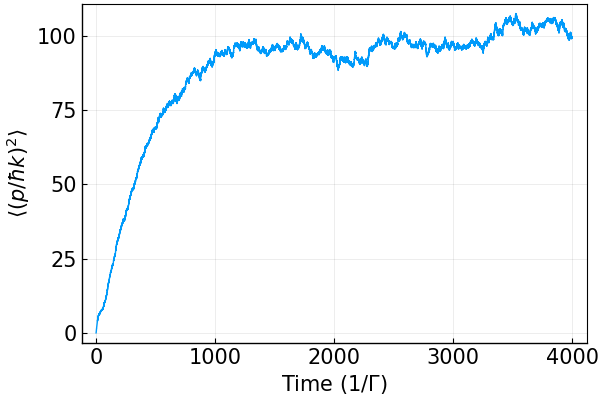

In [423]:
plot(T, p_MCsq[1], label = "",
    frame = true,
    xlabel = L"Time ($1/\Gamma$)",
    ylabel = L"$\langle \left(p/\hbar k \right)^2\rangle$",
    yaxis = font(15),
    xaxis = font(15))